## Exploration of large scientific dataset with OpenVisus and ITKwidgets

### OpenViSUS: install package

To execute this jupyter notebook have to install the package "OpenViSUS"

In conda environments you can use:
```
conda install -c visus OpenVisus
python -m OpenVisus configure
```
Alternatively, you can install it via the Anaconda package manager after adding the "visus" channel to the environment.

In pip envirinments you can use:
```
python -m pip install OpenVisus

python -m OpenVisus configure
```
Note: ignore errors during the "configure" process

### OpenViSUS: read from a remote dataset

In [1]:
%matplotlib notebook

import os,sys

# Here are commands to install a package (OpenVisus) directly from a jupyter notebook
# after you install those once you can comment those comment
!{sys.executable} -m pip install itkwidgets
#!{sys.executable} -m OpenVisus configure

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *

import OpenVisus as ov

# Enable I/O component of OpenVisus
ov.DbModule.attach()

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Starting OpenVisus /usr/local/lib/python3.9/site-packages/OpenVisus/__init__.py 3.9.1 (default, Feb  3 2021, 07:04:15) 
[Clang 12.0.0 (clang-1200.0.32.29)] sys.version_info(major=3, minor=9, micro=1, releaselevel='final', serial=0) ...


In [2]:
# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def showData(data, cmap=None, plot=None):
    if len(data.shape)==3 and data.shape[0]==1: data=data[0,:,:]
    if len(data.shape)==3 and data.shape[1]==1: data=data[:,0,:]   
    if len(data.shape)==3 and data.shape[2]==1: data=data[:,:,0]
    if(plot==None or cmap!=None):
        fig=plt.figure(figsize = (7,5))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot
    

### Navigate time and resolution

In [3]:
# select a remote dataset (satellite imagery from NASA)
# this doesn't actually fetch any data, only metadata
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble")

# what is the size of this dataset ?
# the logic box contains the extent of the dataset on the different axis
#dataset.getLogicBox().toString()
print(dataset.getDatasetBody().toString())

<dataset url="https://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V001010101010101010101010101010101" />
		<box value="0 86400 0 43200" />
		<bitsperblock value="16" />
		<blocksperfile value="256" />
		<block_interleaving value="0" />
		<filename_template value="./bluemarble-compressed/%02x/%04x.bin" />
		<missing_blocks value="False" />
		<time_template value="time%02d/" />
		<physic_box value="0 5760 0 2881" />
		<field name="data" description="" index="" default_compression="zip" default_layout="" default_value="0" filter="" dtype="uint8[3]" />
		<timestep from="0" to="11" step="1" />
	</idxfile>
</dataset>


In [4]:
# what is the maximum resolution ? 
# NOTE: don't use large values of the resolution for large query (you will be fetching too much data)
dataset.getMaxResolution()

33

In [5]:
# what timesteps are defined
dataset.getTimesteps().toString()

'<DatasetTimesteps>\n\t<timestep from="0" to="11" step="1" />\n</DatasetTimesteps>'

<IPython.core.display.Javascript object>


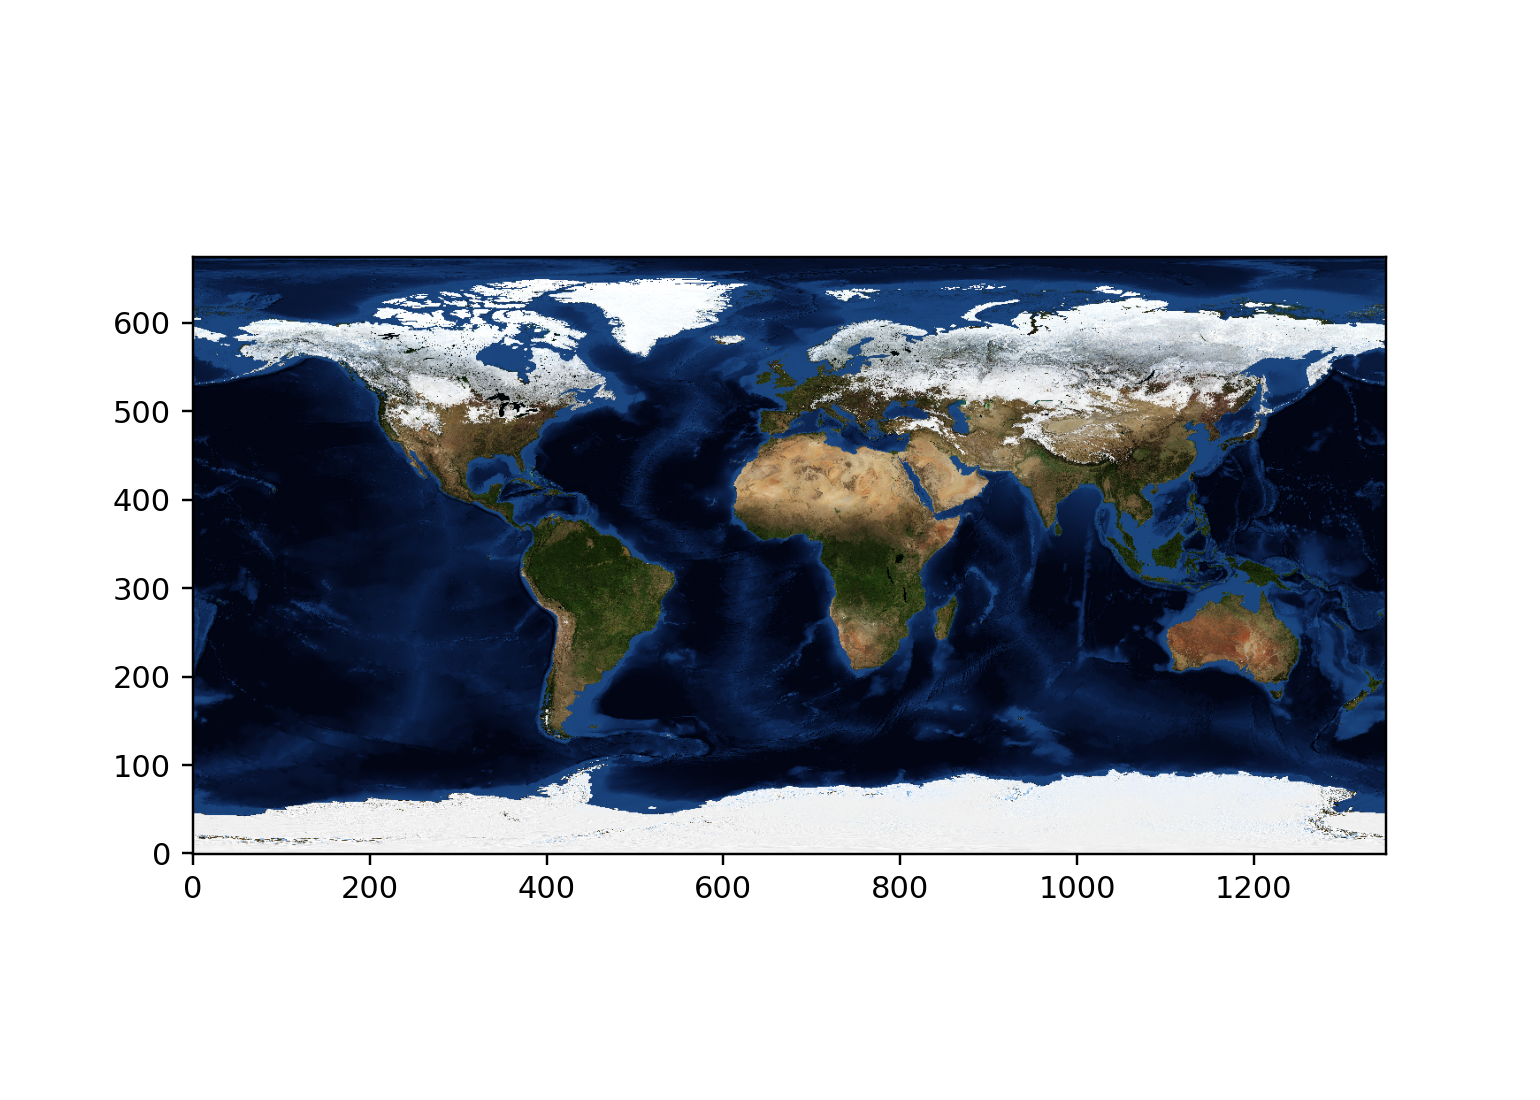

In [6]:
# function to read data from a remote dataset
# optional parameters: timestep, field (variable in the dataset), logic_box (bounding box of the query), resolution

# Note: the resolution value could sometime fetch a dataset with the wrong aspect ratio, 
# this because in the IDX format we double the size at each resolution on only one of the axis at a time

showData(dataset.read(time=0, max_resolution=21))

In [8]:
data = dataset.read(time=0, max_resolution=21)
data.shape

(675, 1350, 3)

<IPython.core.display.Javascript object>


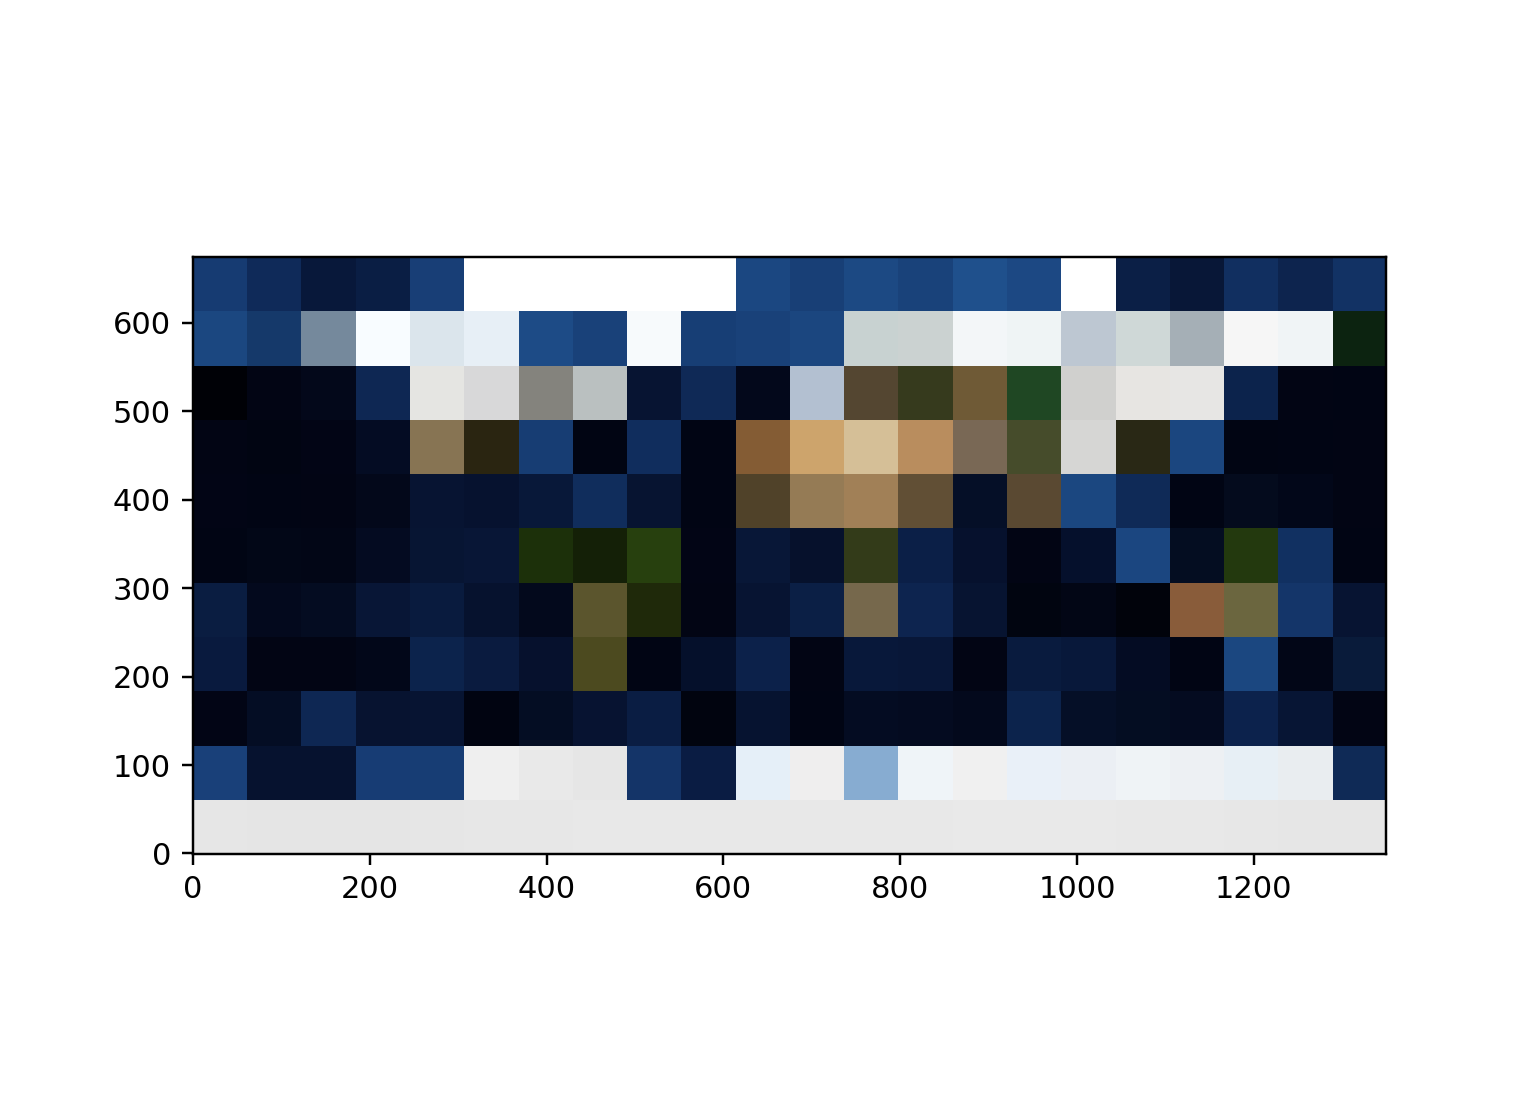

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=9, description='resoluti…

<function __main__.<lambda>(time, resolution)>

In [9]:
# create a plot for our data
myplot = showData(dataset.read(time=0, max_resolution=21))

# reuse the plot with an interact for varying time and resolution values
interact(
    lambda time,resolution: showData(dataset.read(time=time,max_resolution=resolution), plot=myplot),
    time=widgets.IntSlider(value=0,min=0,max=11,step=1), 
    resolution=widgets.IntSlider(value=9,min=1,max=dataset.getMaxResolution(),step=2))

### Interactive analysis

In [11]:
# Open an aerial dataset from the National Ecology Observatory Network 
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=neon_redb")
print(dataset.getDatasetBody().toString())

<dataset url="https://atlantis.sci.utah.edu/mod_visus?dataset=neon_redb" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V0101010101010101010101010101010101" />
		<box value="0 80000 0 100000" />
		<bitsperblock value="16" />
		<blocksperfile value="512" />
		<block_interleaving value="0" />
		<filename_template value="./2017_REDB_1/%02x/%04x.bin" />
		<missing_blocks value="False" />
		<time_template value="" />
		<field name="DATA" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="uint8[3]" />
		<timestep when="0" />
	</idxfile>
</dataset>


<IPython.core.display.Javascript object>


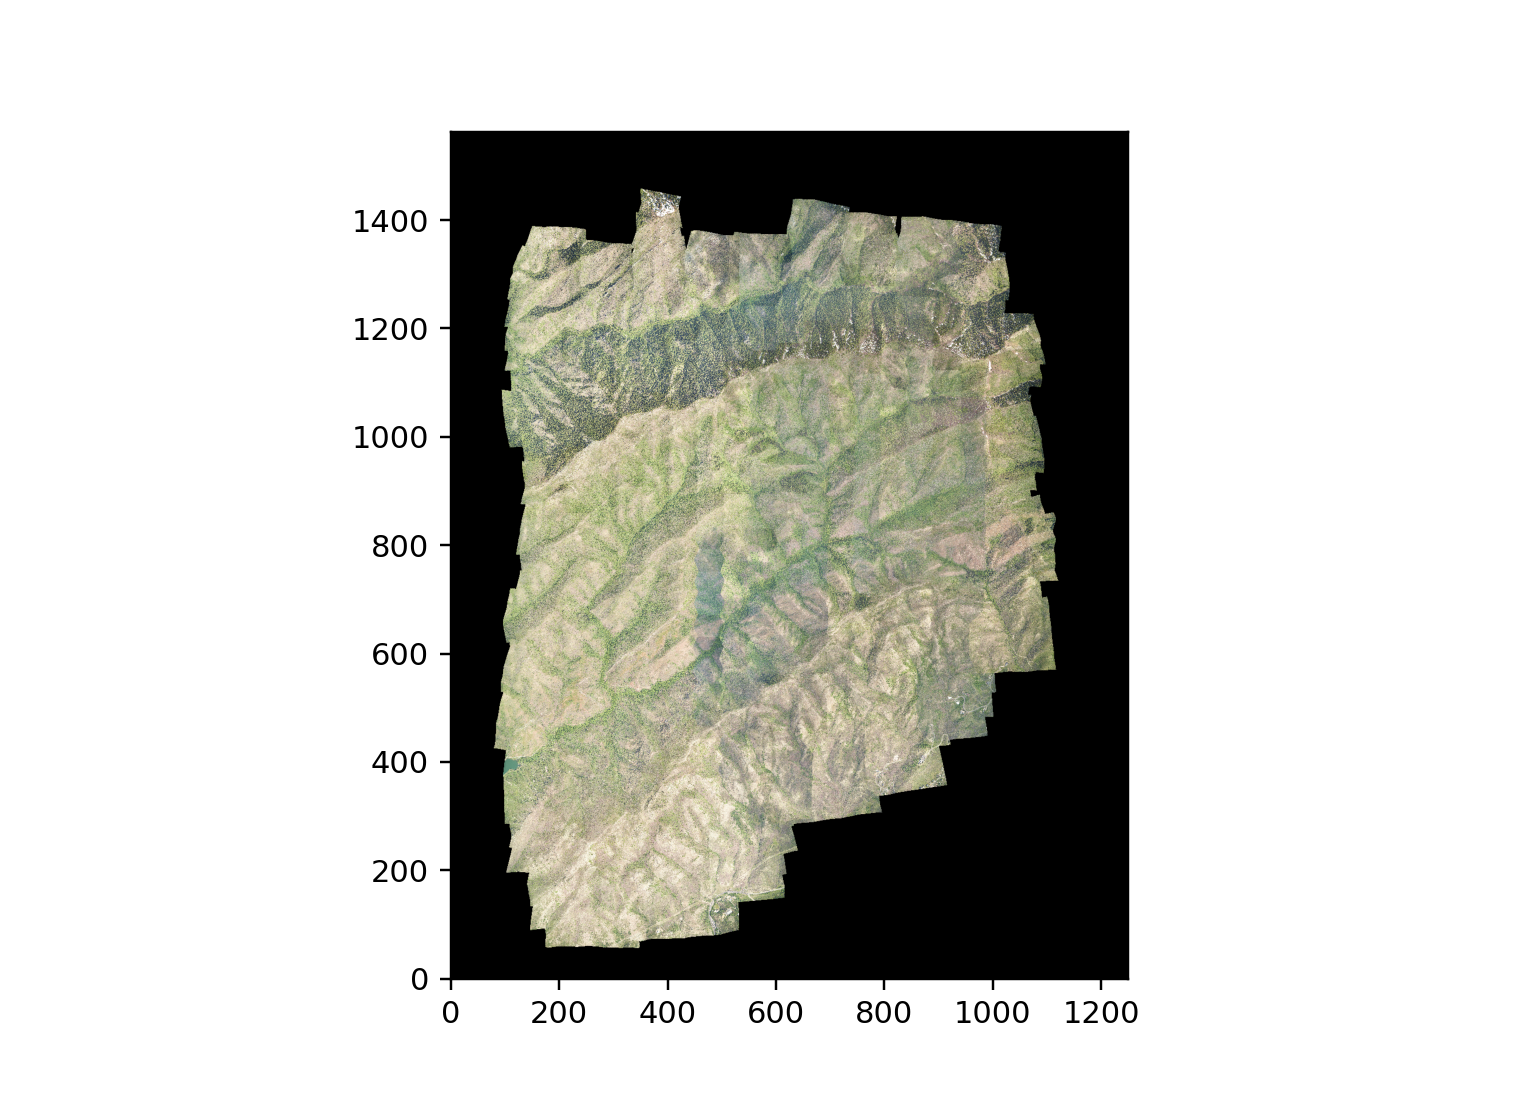

In [12]:
data = dataset.read(max_resolution=22)
showData(data)

In [14]:
# what's the name of the field we are looking at?
dataset.getField().name

'DATA'

In [15]:
# what's the datatype fo this field?
dataset.getField('DATA').dtype.toString()

'uint8[3]'

In [16]:
# what's the size of the data fetched? (note: there are three channels, RGB)
data.shape

(1563, 1250, 3)

In [17]:
# make a "grey scale" version of the data
# from Matlab "rgb2gray" 0.2989 * R + 0.5870 * G + 0.1140 * B (standard ITU-R BT.601-7)

R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
grey_data=R+G+B

<IPython.core.display.Javascript object>


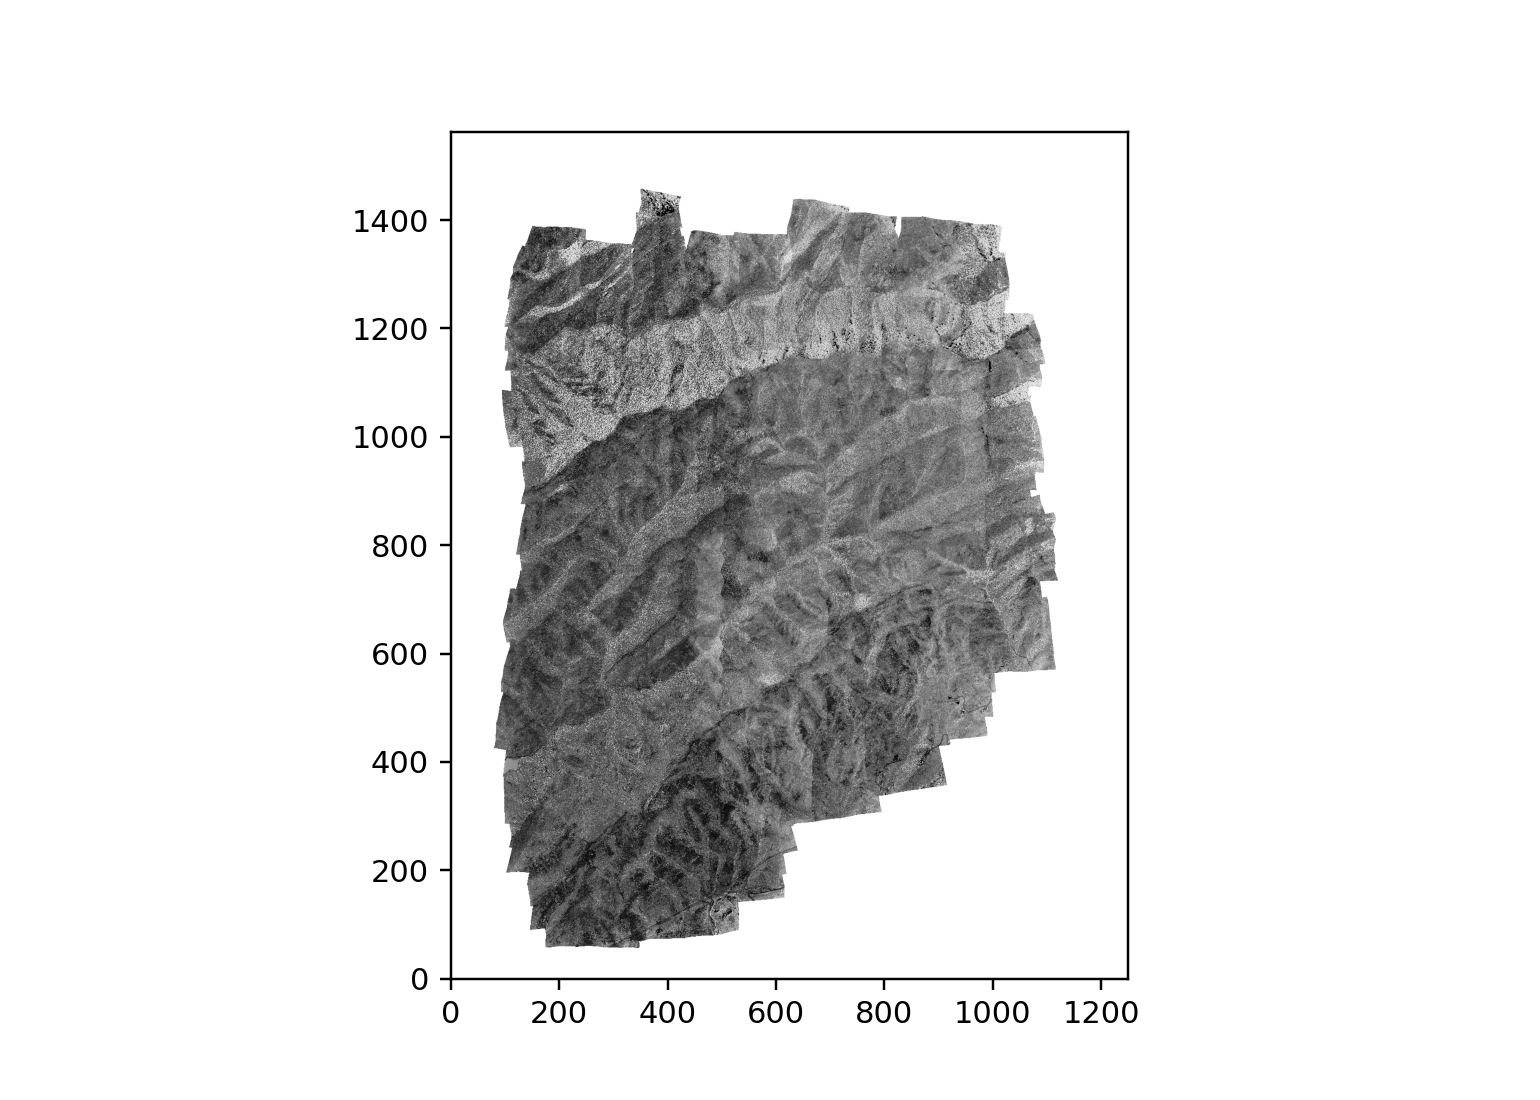

In [18]:
# show data using a grey scale colormap
showData(grey_data, cmap=plt.get_cmap("Greys"))

In [19]:
# make a threshold function to show which "pixel" is above a certain values
def threshold(data, t):
    return data > t

<IPython.core.display.Javascript object>


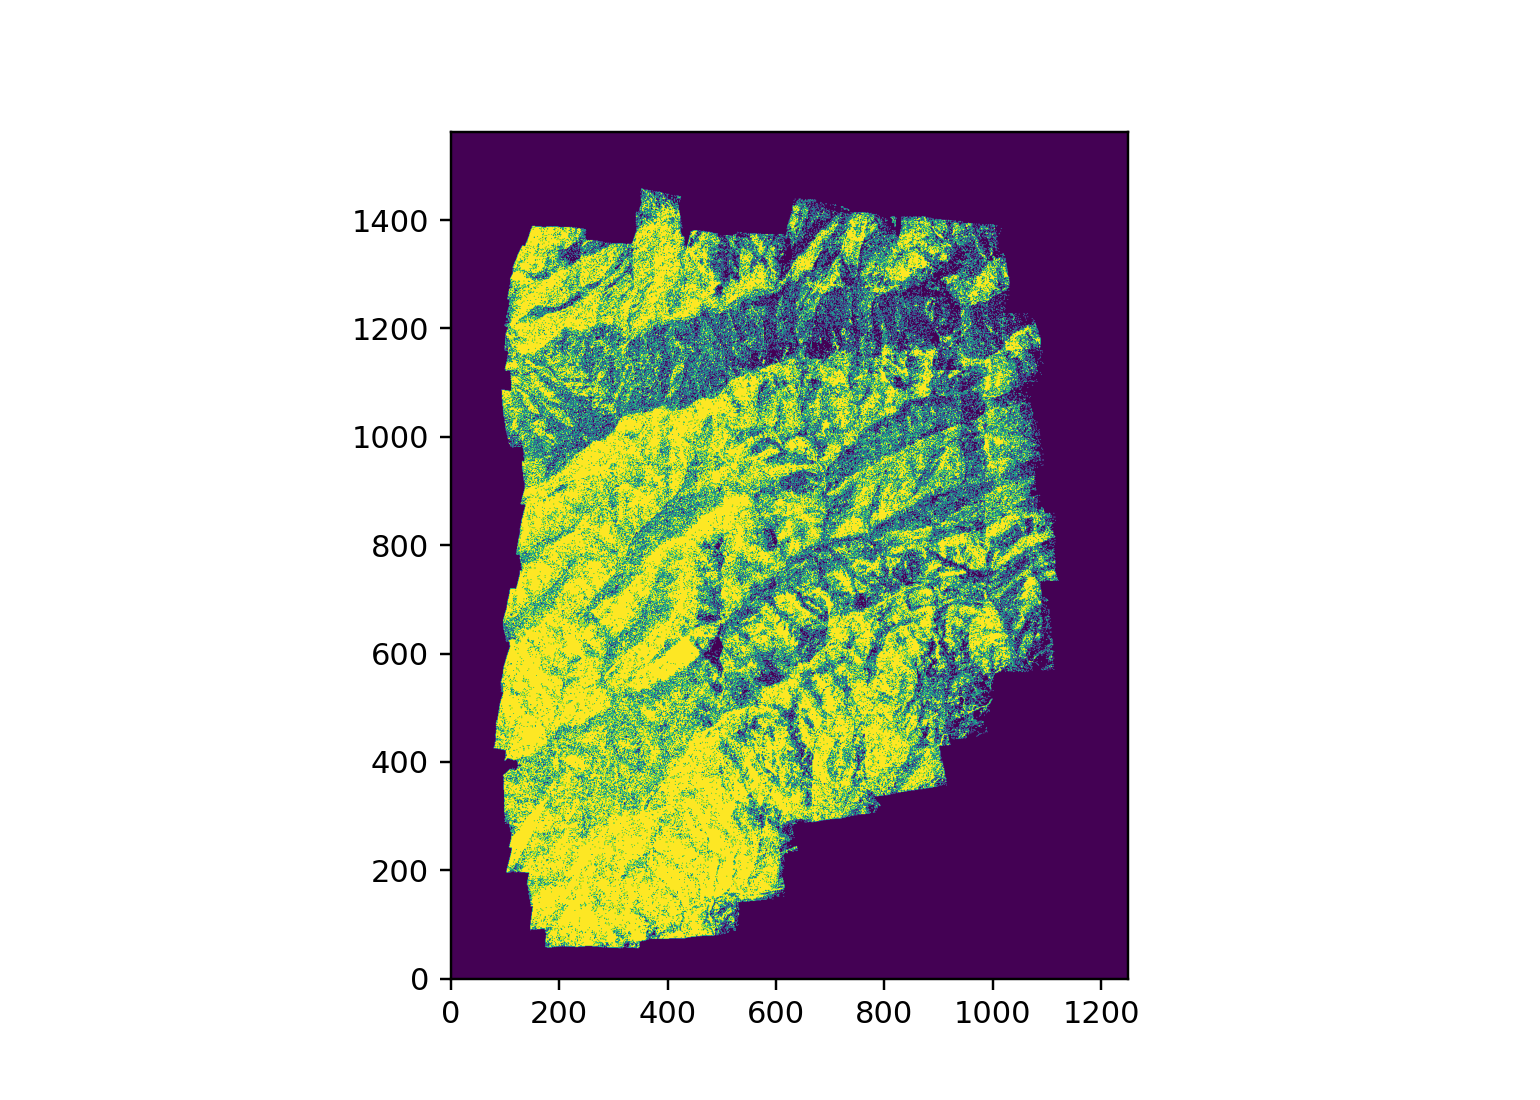

In [20]:
showData(threshold(grey_data, 150))

<IPython.core.display.Javascript object>


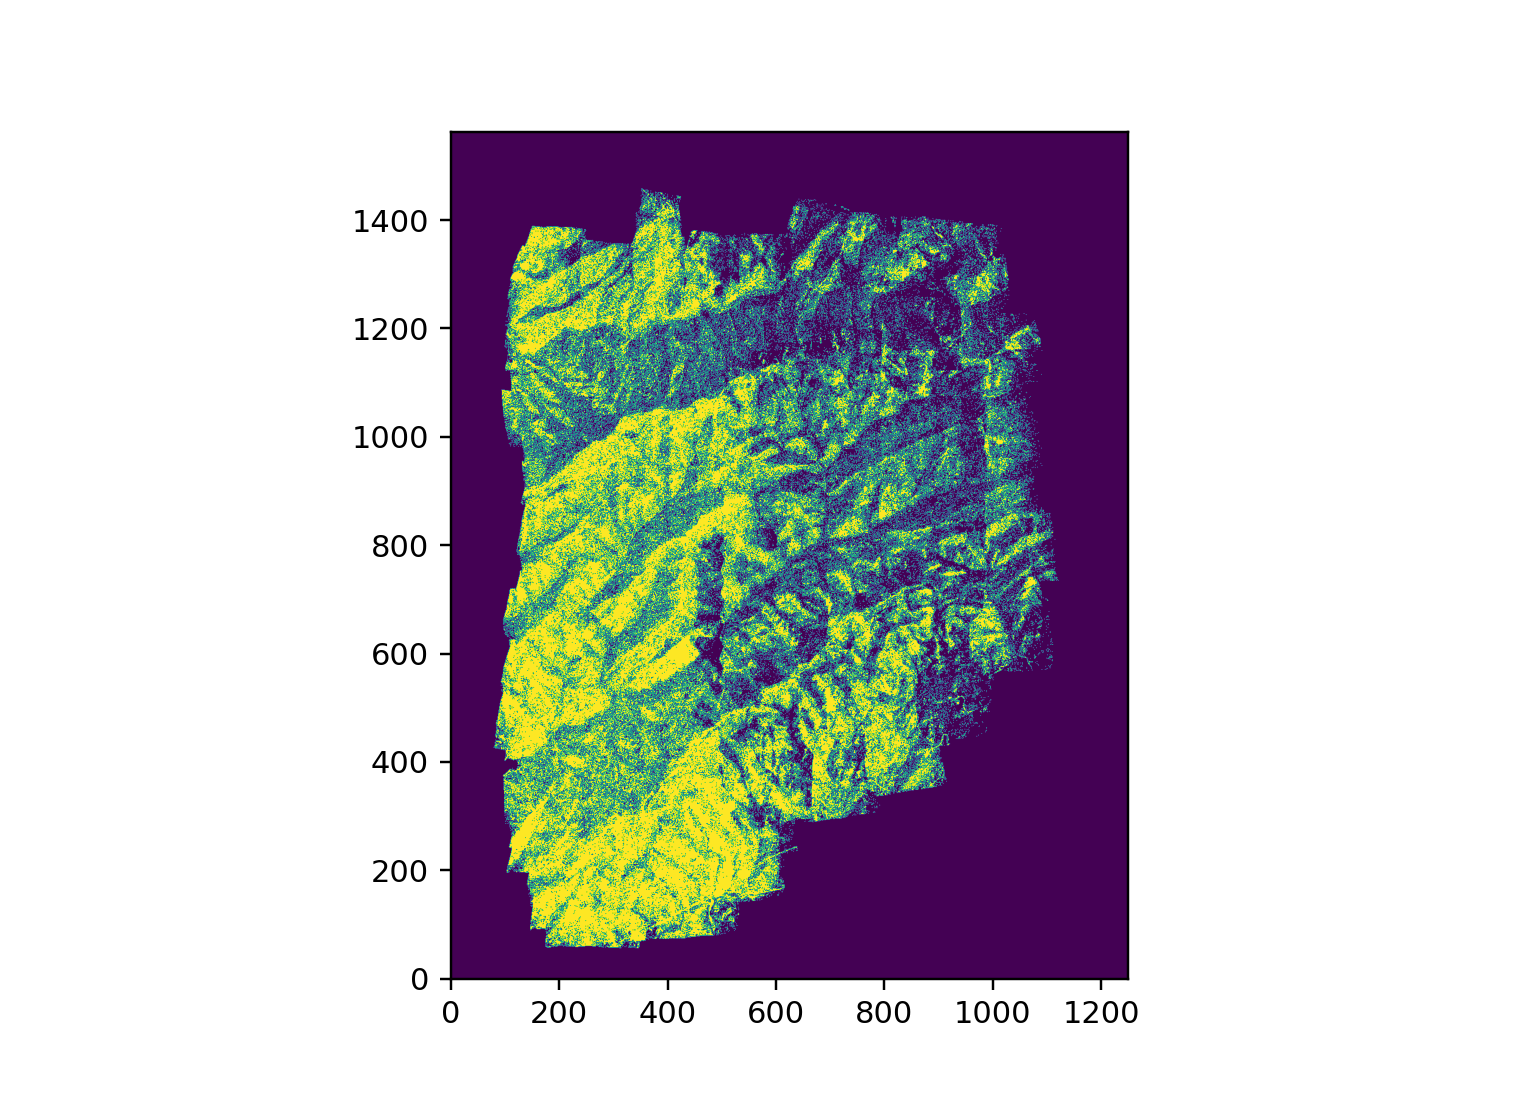

interactive(children=(IntSlider(value=96, description='thr', max=254), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(thr)>

In [21]:
# make the threshold exploration interactive
myplot = showData(threshold(grey_data,t=150))

interact(
    lambda thr: showData(threshold(grey_data,t=thr), plot=myplot),
    thr=widgets.IntSlider(value=np.mean(grey_data),min=np.min(grey_data),max=np.max(grey_data),step=1))

### Working with 3D datasets

In [23]:
import itk
from itkwidgets import view
import itkwidgets

In [24]:
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=borg")
data = dataset.read(time=15, max_resolution=24)

image = itk.image_from_array(data)
viewer = view(image)

In [25]:
display(viewer)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [26]:
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1")
# how big is the dataset ?
print(dataset.getDatasetBody().toString())

<dataset url="https://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V012012012012012012012012012012012" />
		<box value="0 2048 0 2048 0 2048" />
		<bitsperblock value="16" />
		<blocksperfile value="256" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%02x/%04x.bin" />
		<missing_blocks value="False" />
		<time_template value="" />
		<field name="DATA" description="" index="" default_compression="zip" default_layout="hzorder" default_value="0" filter="" dtype="uint8" />
		<timestep when="0" />
	</idxfile>
</dataset>


(1, 128, 128)


<IPython.core.display.Javascript object>


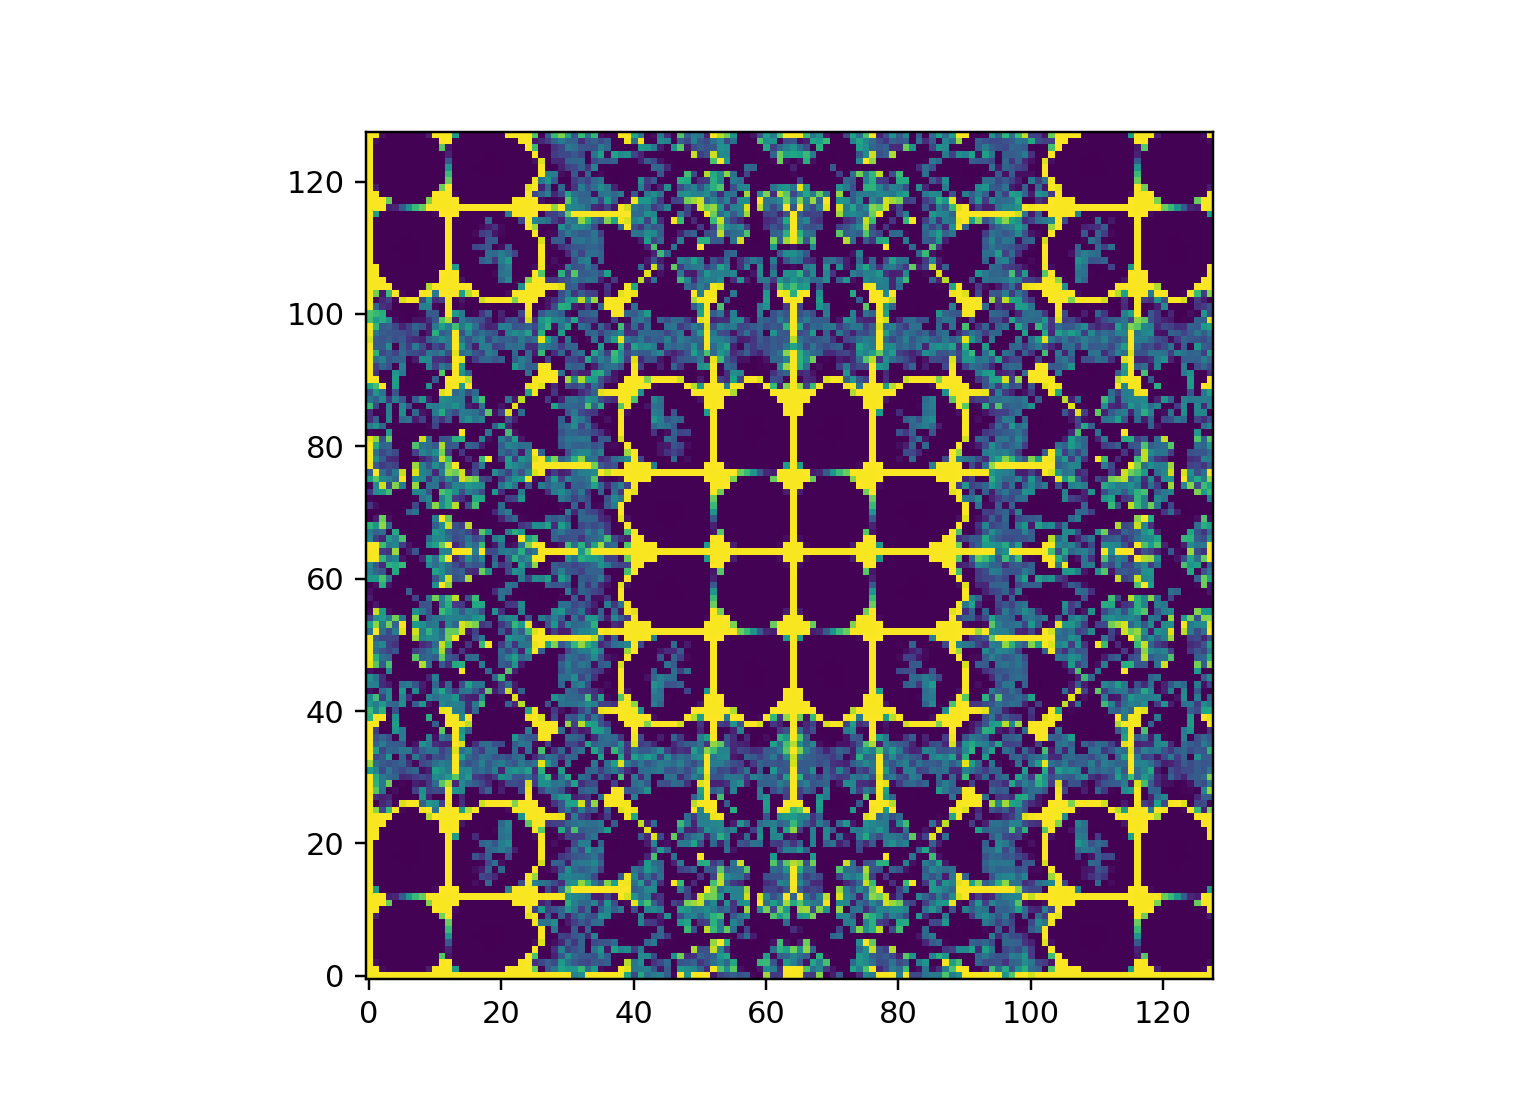

In [27]:
# make a query to fetch a slice of this 3D dataset (in the middle of the 3rd axis)
data=dataset.read(x=[0,2048],y=[0,2048],z=[1024,1025],max_resolution=21)
print(data.shape)
showData(data)

### Use ITK widgets

This requires you to install the *itkwidgets* package.

In [83]:
# import itk libraries and the "view" function

import itk
from itkwidgets import view
import itkwidgets

In [84]:
# use itkwidgets to explore and visualize 3D data
data=dataset.read(max_resolution=21)
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [85]:
# loading a large 2D microscopy dataset showing the retina of a rabbit
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=rabbit")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox()

([0, 0], [131072, 131072])

In [31]:
# get default field name
dataset.getField().name

'EM'

In [32]:
# get default field datatype 
# dataset.getField().dtype.toString()

<IPython.core.display.Javascript object>


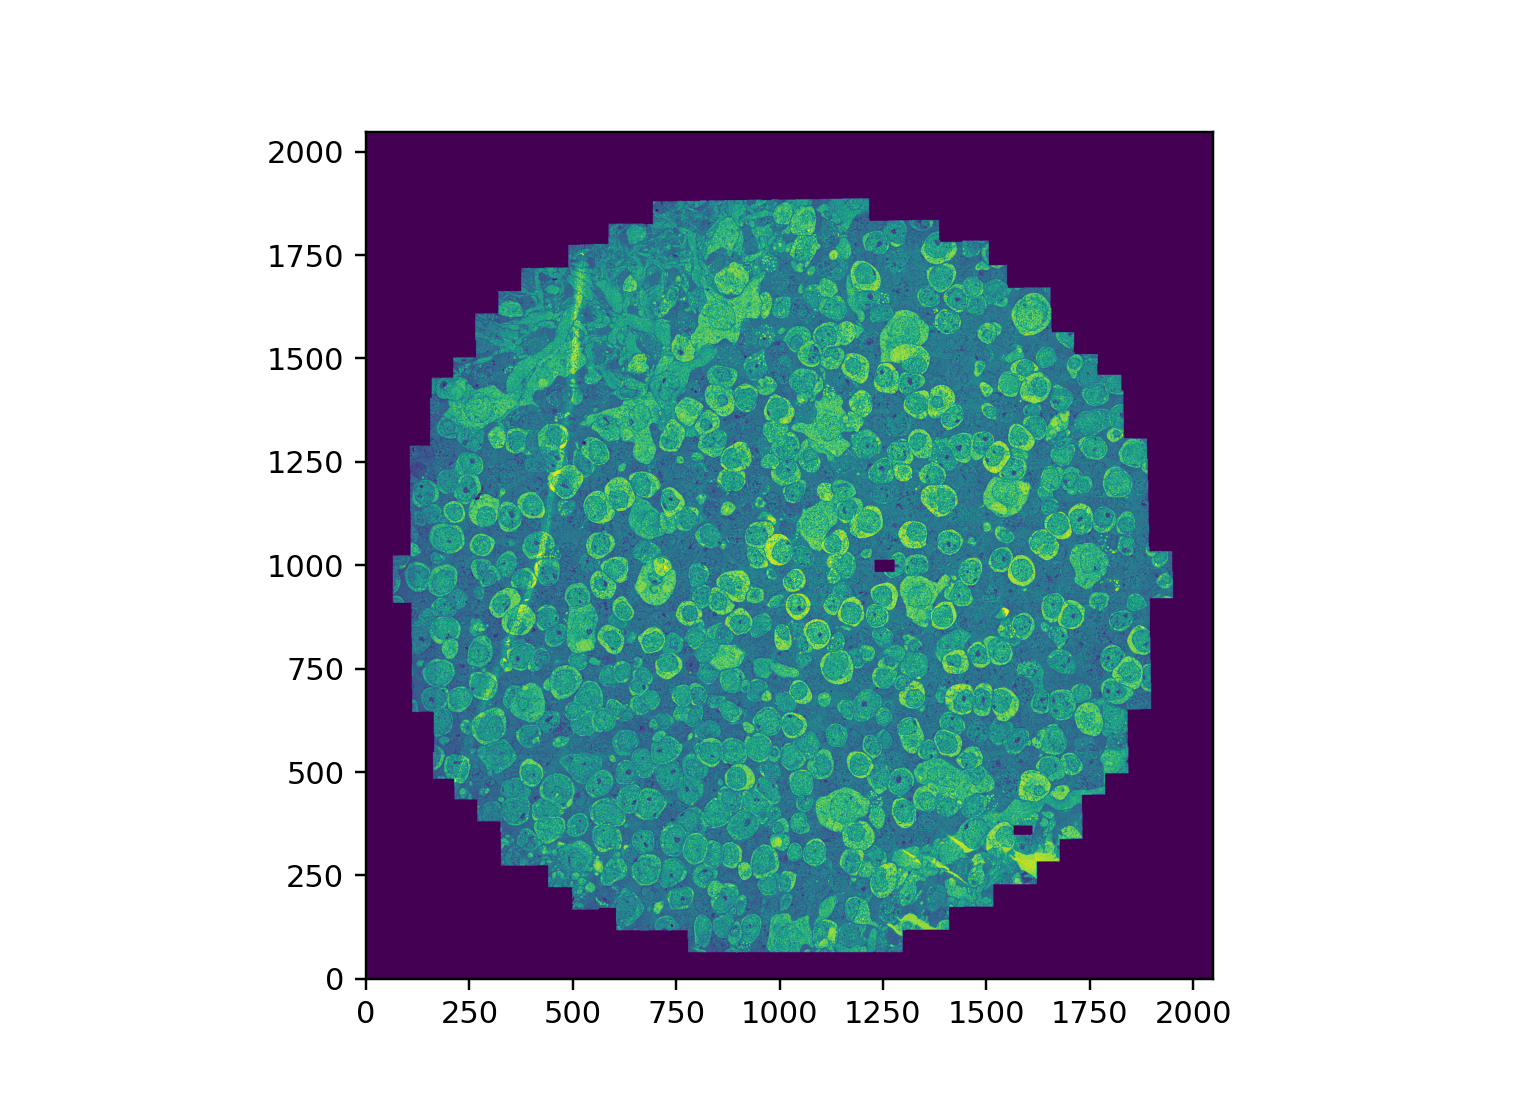

In [33]:
data=dataset.read(max_resolution=22)
showData(data)

In [34]:
# open a 3D version of this dataset
dataset=ov.LoadDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=rabbit3d")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox()

([0, 0, 0], [131072, 131072, 341])

In [35]:
# almost 6TB size, can we still visualize it on this browser?
131073*131073*342/(1024*1024*1024)

5472.083496412262

In [36]:
data=dataset.read(max_resolution=21)
view(data)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### Voxel spacing

Microscopy data or CT scan often have different resolution along the axis, in order to make a realistic visualization we need to use correct voxel spacing

In [37]:
# to edit the voxel spacing we need to transform our numpy array into an itk data structure
itk_array = itk.image_from_array(data)
# read the current spacing (uniform)
itk_array.GetSpacing()

itkVectorD3 ([1, 1, 1])

In [38]:
# set a new spacing
itk_array.SetSpacing([1.0, 1.0, 0.1])
view(itk_array)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [39]:
# we open a metallic foam dataset
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=foam")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox()

([0, 0, 0], [1055, 1024, 1024])

In [82]:
# Visualize and explore the dataset 
# How can we evaluate the density of material?

data=dataset.read(max_resolution=18)
view(data, select_roi=True)

NameError: name 'view' is not defined

In [59]:
# Evaluate the density of material 
mat_interface_val = 10000
count = (data > mat_interface_val).sum()
density = count/(data.shape[0]*data.shape[1]*data.shape[2])
density


0.3226355350378788

In [62]:
def density_res(res):
    data=dataset.read(max_resolution=res)
    count = (data > mat_interface_val).sum()
    density = count/(data.shape[0]*data.shape[1]*data.shape[2])
    return density

In [63]:
density_res(21)

0.3249557957504735

In [64]:
density_res(20)

0.32427238695549243

In [65]:
density_res(18)

0.3226355350378788

In [190]:
density_res(17)

0.04532137784090909

In [66]:
density_res(15)

0.3151041666666667

In [67]:
density_res(10)

0.3107638888888889

In [68]:
density_res(23)

0.32539067123875476

# PyVista

In [7]:
import pyvista as pv

In [111]:
# we open the borg dataset
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=borg")
# how big is the dataset ?
# the logic box contains the extent of the dataset on the different axis
dataset.getLogicBox()


([0, 0, 0], [1152, 1152, 1152])

In [118]:
data=dataset.read(max_resolution=21, time=13)

In [119]:
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(data.shape) + 1

# Edit the spatial reference
#grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
#grid.spacing = (1, 5, 2)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = data.flatten(order="F")  # Flatten the array!

# Now plot the grid!
grid.plot(volume="True",cmap="bone", jupyter_backend='panel')

In [97]:
data.shape

(1024, 2048)